<a href="https://colab.research.google.com/github/llunasanz/data-project-3/blob/feature%2Fdata_processing/data_cleaning_all_(PARTE_PCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sweetviz

     |████████████████████████████████| 15.1 MB 4.7 MB/s 


In [2]:
!pip install mglearn

     |████████████████████████████████| 540 kB 5.3 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=d566edd5ec6c97cea6914d8d2a06d4b54e1414d3784e9859036c41cce18d8043
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


## Importanción de Librerías

In [171]:
import pandas as pd
#import pyspark as ps
import datetime as dt
import sweetviz as sv
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.decomposition import PCA
import mglearn
import multiprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')





pd.set_option('display.max_columns', None)


In [4]:
def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

In [5]:
def groupby_method(df, method: str):
    df_t = df.copy()
    dict_rename = {"loanamount": f"loanamount_{method}", 
               "totaldue": f"totaldue_{method}", 
               "termdays": f"termdays_{method}", 
               "diffcreaaprov": f"diffcreaaprov_{method}", 
               "diffpaid": f"diffpaid_{method}", 
               "diffclosecrea": f"diffclosecrea_{method}",
               "diffclose1rep": f"diffclose1rep_{method}", 
               "duration_ratio": f"duration_ratio_{method}"
              }
    df_t.rename(dict_rename, axis = 1, inplace = True)
    if method == "min":
        df_t = df_t.groupby(by=["customerid"]).min()
    if method == "1q":
        df_t = df_t.groupby(by=["customerid"]).quantile(.25)
    if method == "median":
        df_t = df_t.groupby(by=["customerid"]).median()
    if method == "3q":
        df_t = df_t.groupby(by=["customerid"]).quantile(.75)
    if method == "max":
        df_t = df_t.groupby(by=["customerid"]).max()
    
    
    return(df_t)

## CARGA Y LIMPIEZA DE DATOS

### Cargamos los datos de los diferentes CSV para su posterior limpieza de variables






In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Usamos pandas para leer de los csv 
df_tr_demo = pd.read_csv('/content/drive/MyDrive/DP3/data/train_datos_demograficos.csv')
df_ts_demo = pd.read_csv('/content/drive/MyDrive/DP3/data/test_datos_demograficos.csv')

df_tr_previous = pd.read_csv('/content/drive/MyDrive/DP3/data/train_previous_loan.csv')
df_ts_previous = pd.read_csv('/content/drive/MyDrive/DP3/data/test_previous_loan.csv')

df_tr_performance = pd.read_csv('/content/drive/MyDrive/DP3/data/train_performance.csv')
df_ts_performance = pd.read_csv('/content/drive/MyDrive/DP3/data/test_performance.csv')

df_sample = pd.read_csv('/content/drive/MyDrive/DP3/data/SampleSubmission.csv')

In [10]:
df_ts_performance = df_ts_performance.merge(df_sample, on = "customerid", how = "left")
df_ts_performance.rename(columns = {"Good_Bad_flag": "good_bad_flag"}, inplace=True)

In [11]:
# Concatenate
df_demo = pd.concat([df_tr_demo, df_ts_demo], axis = 0)
df_previous = pd.concat([df_tr_previous, df_ts_previous], axis = 0)
df_performance = pd.concat([df_tr_performance, df_ts_performance], axis = 0)

#### Previous

In [12]:
# Previous
df_previous_t = df_previous.copy()

df_previous_t["diffcreaaprov"] = pd.to_datetime(
    df_previous_t.approveddate) - pd.to_datetime(df_previous_t.creationdate
)
df_previous_t.diffcreaaprov = df_previous_t.diffcreaaprov.dt.total_seconds()/3600

df_previous_t["diffpaid"] = pd.to_datetime(
    df_previous_t.firstrepaiddate) - pd.to_datetime(df_previous_t.firstduedate
)
df_previous_t.diffpaid = df_previous_t.diffpaid.dt.total_seconds()/3600

df_previous_t["diffclosecrea"] = pd.to_datetime(
    df_previous_t.closeddate) - pd.to_datetime(df_previous_t.creationdate
)
df_previous_t.diffclosecrea = df_previous_t.diffclosecrea.dt.total_seconds()/3600/24

df_previous_t["diffclose1rep"] = pd.to_datetime(
    df_previous_t.closeddate) - pd.to_datetime(df_previous_t.firstrepaiddate
)
df_previous_t.diffclose1rep = df_previous_t.diffclose1rep.dt.total_seconds()/3600/24

df_previous_t["duration_ratio"] = df_previous_t.diffclose1rep / df_previous_t.termdays
# df_previous_t.diffclosecrea = df_previous_t.diffclosecrea.dt.total_seconds()/3600


df_previous_t.referredby = list(map(lambda x: 0 if pd.isna(x) else 1, list(df_previous_t.referredby)))
# df_previous_t['termlength'] = pd.cut(df_previous_t['termdays'],[0,16,61,89], labels = ['short','medium','large'])


n_loans = list(df_previous_t[["customerid", "loannumber"]].groupby(by=["customerid"]).count()['loannumber'])
df_previous_t.drop(['systemloanid', "loannumber", 'creationdate', 'approveddate', 'firstduedate', 'firstrepaiddate', 'referredby', 'closeddate'], axis=1, inplace=True)


df_previous_min = groupby_method(df_previous_t, "min")

df_previous_max = groupby_method(df_previous_t, "max")

df_previous_median = groupby_method(df_previous_t, "median")

df_previous_1q = groupby_method(df_previous_t, "1q")

df_previous_3q = groupby_method(df_previous_t, "3q")


df_previous_median["nloans"] = n_loans
df_previous_t.reset_index(inplace = True)

df_previous_t

,index,customerid,loanamount,totaldue,termdays,diffcreaaprov,diffpaid,diffclosecrea,diffclose1rep,duration_ratio
0,0,8a2a81a74ce8c05d014cfb32a0da1049,10000.0,13000.0,30,1.002222,-296.138056,16.947407,0.010475,0.000349
1,1,8a2a81a74ce8c05d014cfb32a0da1049,10000.0,13000.0,30,1.003889,-96.000000,29.879120,2.614456,0.087149
2,2,8a2a81a74ce8c05d014cfb32a0da1049,20000.0,23800.0,30,1.001667,550.063056,52.515706,0.010521,0.000351
3,3,8a8588f35438fe12015444567666018e,10000.0,11500.0,15,1.003611,0.811944,14.340394,0.032743,0.002183
4,4,8a85890754145ace015429211b513e16,10000.0,11500.0,15,1.001944,285.143056,27.533947,0.007037,0.000469
...,...,...,...,...,...,...,...,...,...,...
24085,5902,8a858f085b494826015b54a0b2a1093b,10000.0,13000.0,30,1.006111,-145.801667,23.015891,0.010521,0.000351
24086,5903,8a858f565b683b56015b7391c2617960,10000.0,11500.0,15,1.003333,-148.707500,9.874734,0.010521,0.000701
24087,5904,8a858fab5b9105dc015b975e594e394a,10000.0,13000.0,30,1.018889,-298.957222,16.935683,0.007049,0.000235
24088,5905,8a858fcf5b39c3ba015b39c7691603e1,10000.0,13000.0,30,1.001667,-2.164722,29.669595,0.007060,0.000235


#### Demographic

In [13]:
df_demo_t = df_demo.copy()

df_demo_t["age"] = max(pd.to_datetime(df_tr_performance.creationdate)) - pd.to_datetime(df_demo_t.birthdate)
df_demo_t.age = df_demo_t.age.dt.total_seconds()/3600/24/365

df_demo_t.employment_status_clients = list(map(lambda x: "Other" if pd.isna(x) else x, list(df_demo_t.employment_status_clients)))
df_demo_t.level_of_education_clients = list(map(lambda x: "Other" if pd.isna(x) else x, list(df_demo_t.level_of_education_clients)))

df_demo_t.drop(["bank_branch_clients", "birthdate"], axis = 1, inplace = True)
df_demo_t.drop_duplicates(subset=["customerid"], keep="last", inplace=True)

df_demo_t

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,age
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,Other,Other,43.835380
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,Permanent,Other,31.544969
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,Other,Other,30.353188
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.362850,6.642485,GT Bank,Permanent,Other,26.051818
4,8a858e785acd3412015acd48f4920d04,Savings,8.455332,11.971410,GT Bank,Permanent,Other,34.712092
...,...,...,...,...,...,...,...,...
1482,8a858fc25bafabdc015bb47fda0323e5,Savings,3.481190,6.442728,GT Bank,Permanent,Other,41.325791
1483,8a858e245c214660015c3397e4db389a,Savings,4.738209,8.179723,GT Bank,Permanent,Other,26.786065
1484,8a858e8b5bc9e7e6015bcd7374077f0c,Savings,3.424825,6.455802,First Bank,Permanent,Other,29.153188
1485,8a858f2e5c699f3a015c77aa22ed7f23,Savings,3.318851,7.113212,FCMB,Permanent,Other,43.386065


#### Performance (train)

In [14]:
df_tr_performance_t = df_tr_performance.copy()
# df_tr_performance_t['termlength'] = pd.cut(df_tr_performance_t['termdays'],[0,16,61,89], labels = ['short','medium','large'])
df_tr_performance_t.referredby = list(map(lambda x: 0 if pd.isna(x) else 1, list(df_tr_performance_t.referredby)))
df_tr_performance_t.good_bad_flag = list(map(lambda x: 0 if x == "Good" else 1, list(df_tr_performance_t.good_bad_flag)))
df_tr_performance_t["loan_due_ratio"] = df_tr_performance_t.loanamount/df_tr_performance_t.totaldue

df_tr_performance_t.drop(["systemloanid", "loannumber", "approveddate", "creationdate"], axis = 1, inplace = True)

df_tr_performance_t

,customerid,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,0,0.869565
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,0,0,0.869565
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,0,0.898876
3,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,0,0.869565
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,0,0.909091
...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,10000.0,13000.0,30,0,1,0.769231
4364,8a858ee85cf400f5015cf44ab1c42d5c,10000.0,13000.0,30,0,1,0.769231
4365,8a858f365b2547f3015b284597147c94,10000.0,11500.0,15,0,1,0.869565
4366,8a858f935ca09667015ca0ee3bc63f51,10000.0,13000.0,30,1,1,0.769231


#### Merged data

In [15]:
df_tr_all = df_tr_performance_t.merge(df_previous_median, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_previous_min, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_previous_max, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_previous_1q, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_previous_3q, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_demo_t, on = "customerid", how = "left")

df_tr_all.dropna(inplace=True)
# df_all[df_all.isna().any(axis=1)]

df_tr_all.to_csv('/content/drive/MyDrive/DP3/data/merged_ts.csv')

#### Merged data test

In [16]:
df_ts_performance_t = df_ts_performance.copy()
# df_tr_performance_t['termlength'] = pd.cut(df_tr_performance_t['termdays'],[0,16,61,89], labels = ['short','medium','large'])
df_ts_performance_t.referredby = list(map(lambda x: 0 if pd.isna(x) else 1, list(df_ts_performance_t.referredby)))
# df_ts_performance_t.good_bad_flag = list(map(lambda x: 0 if x == "Good" else 1, list(df_ts_performance_t.good_bad_flag)))
df_ts_performance_t["loan_due_ratio"] = df_ts_performance_t.loanamount/df_ts_performance_t.totaldue

df_ts_performance_t.drop(["systemloanid", "loannumber", "approveddate", "creationdate"], axis = 1, inplace = True)
df_ts_performance_t.rename(columns = {"Good_Bad_flag": "good_bad_flag"}, inplace=True)

df_ts_performance_t

,customerid,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio
0,8a858899538ddb8e015390510b321f08,10000,12250.0,30,0,1,0.816327
1,8a858959537a097401537a4e316e25f7,40000,44000.0,30,0,1,0.909091
2,8a8589c253ace09b0153af6ba58f1f31,20000,24500.0,30,0,1,0.816327
3,8a858e095aae82b7015aae86ca1e030b,30000,34500.0,30,0,1,0.869565
4,8a858e225a28c713015a30db5c48383d,20000,24500.0,30,0,1,0.816327
...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,10000,11500.0,15,0,1,0.869565
1446,8a858fcb5b00cc54015b0253ced26a5f,10000,13000.0,30,0,1,0.769231
1447,8a858fde56eb02280156f59b976d46c0,40000,48000.0,60,0,1,0.833333
1448,8a858e10570f2d65015717fcfec44996,60000,68100.0,90,0,1,0.881057


In [17]:
df_ts_all = df_ts_performance_t.merge(df_previous_median, on = "customerid", how = "left")
df_ts_all = df_ts_all.merge(df_previous_min, on = "customerid", how = "left")
df_ts_all = df_ts_all.merge(df_previous_max, on = "customerid", how = "left")
df_ts_all = df_ts_all.merge(df_previous_1q, on = "customerid", how = "left")
df_ts_all = df_ts_all.merge(df_previous_3q, on = "customerid", how = "left")
df_ts_all = df_ts_all.merge(df_demo_t, on = "customerid", how = "left")

df_ts_all.dropna(inplace=True)
# df_all[df_all.isna().any(axis=1)]

df_ts_all

,customerid,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,age
0,8a858899538ddb8e015390510b321f08,10000,12250.0,30,0,1,0.816327,10000.0,13000.0,30.0,1.002222,15.735556,30.602315,0.347303,0.011577,3.0,6000.0,6900.0,15.0,1.001389,-11.490000,14.219259,0.218785,0.007293,10000.0,13000.0,30.0,1.002222,282.823056,41.155833,0.480822,0.032055,8000.0,9950.0,22.5,1.001806,2.122778,22.410787,0.283044,0.009435,10000.0,13000.0,30.0,1.002222,149.279306,35.879074,0.414062,0.021816,Other,5.835219,8.274730,First Bank,Permanent,Other,33.646339
1,8a858959537a097401537a4e316e25f7,40000,44000.0,30,0,1,0.909091,30000.0,34400.0,30.0,1.001667,-79.870278,25.829236,0.010544,0.000351,9.0,5000.0,6500.0,15.0,1.001389,-224.307222,15.527222,0.007049,0.000176,40000.0,44000.0,60.0,1.004167,43.240000,31.440648,0.637882,0.042525,10000.0,13000.0,30.0,1.001667,-155.328056,23.003762,0.010509,0.000235,30000.0,36800.0,30.0,1.001944,-26.503889,28.591516,0.293021,0.009767,Savings,3.245768,6.601778,First Bank,Permanent,Other,31.339490
2,8a8589c253ace09b0153af6ba58f1f31,20000,24500.0,30,0,1,0.816327,10000.0,13000.0,30.0,1.001944,11.316944,29.151771,0.010532,0.000351,5.0,10000.0,11500.0,15.0,1.001667,-41.605000,16.659653,0.007049,0.000235,20000.0,23800.0,30.0,1.019167,524.567222,53.218877,0.735463,0.024515,10000.0,13000.0,30.0,1.001944,-34.952222,27.953623,0.010451,0.000348,15000.0,18375.0,30.0,1.002222,39.376111,31.921481,0.361389,0.024093,Savings,3.227945,6.586668,UBA,Permanent,Other,35.925791
3,8a858e095aae82b7015aae86ca1e030b,30000,34500.0,30,0,1,0.869565,20000.0,21900.0,15.0,1.001944,-35.970833,14.067616,0.010509,0.000701,7.0,10000.0,11500.0,15.0,1.001667,-253.916389,3.771944,0.007060,0.000235,30000.0,34500.0,30.0,1.019167,-3.415556,26.702083,0.010532,0.000702,10000.0,11500.0,15.0,1.001667,-68.708472,11.994172,0.007078,0.000472,20000.0,22250.0,15.0,1.010278,-7.187361,14.312778,0.010521,0.000701,Savings,6.106486,7.287064,Zenith Bank,Other,Other,39.731270
4,8a858e225a28c713015a30db5c48383d,20000,24500.0,30,0,1,0.816327,10000.0,13000.0,30.0,1.001944,-79.935833,25.910926,0.007060,0.000235,3.0,10000.0,11500.0,15.0,1.001944,-132.544167,14.574340,0.007060,0.000235,10000.0,13000.0,30.0,1.004722,9.873333,26.397106,0.010521,0.000701,10000.0,12250.0,22.5,1.001944,-106.240000,20.242633,0.007060,0.000235,10000.0,13000.0,30.0,1.003333,-35.031250,26.154016,0.008791,0.000468,Savings,5.248368,13.059864,UBA,Permanent,Other,41.961407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,10000,11500.0,15,0,1,0.869565,10000.0,11500.0,15.0,1.010417,-125.600278,10.166319,0.008785,0.000586,2.0,10000.0,11500.0,15.0,1.001944,-200.317222,7.275833,0.007049,0.000470,10000.0,11500.0,15.0,1.018889,-50.883333,13.056806,0.010521,0.000701,10000.0,11500.0,15.0,1.006181,-162.958750,8.721076,0.007917,0.000528,10000.0,11500.0,15.0,1.014653,-88.241806,11.611563,0.009653,0.000644,Savings,3.379678,6.541521,First Bank,Permanent,Other,27.325791
1446,8a858fcb5b00cc54015b0253ced26a5f,10000,13000.0,30,0,1,0.769231,10000.0,11500.0,15.0,

In [18]:
df_ts_all.to_csv('/content/drive/MyDrive/DP3/data/merged_ts.csv')

### All data merged

In [98]:
df_tr_all

,customerid,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Current,bat_Other,bat_Savings,bnc_Access Bank,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Contract,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Graduate,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,0,0.869565,20000.0,23800.0,30.0,1.002500,-96.000000,29.428958,0.010521,0.000351,11.0,10000.0,13000.0,30.0,1.001667,-677.829444,1.250081,0.007049,0.000235,30000.0,34500.0,30.0,8.012778,949.086389,69.095544,2.614456,0.087149,15000.0,18400.0,30.00,1.002222,-236.452917,20.532645,0.010469,0.000349,20000.0,24500.0,30.00,1.003472,177.918194,37.370961,0.010544,0.000351,3.432010,6.433055,45.572366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,0,0.898876,10000.0,11500.0,15.0,1.002500,-75.045278,14.534936,0.010532,0.000702,6.0,10000.0,11500.0,15.0,1.001667,-239.712222,5.846192,0.010532,0.000351,10000.0,13000.0,30.0,1.004722,736.543333,45.285671,0.032743,0.002183,10000.0,11500.0,15.00,1.002014,-173.847708,8.784439,0.010532,0.000702,10000.0,11500.0,15.00,1.003403,3.297569,22.484896,0.018388,0.001226,11.139350,10.292041,32.887435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,0,0.869565,10000.0,12250.0,22.5,1.001944,202.045972,31.883738,0.007043,0.000352,2.0,10000.0,11500.0,15.0,1.001944,118.948889,27.533947,0.007037,0.000235,10000.0,13000.0,30.0,1.001944,285.143056,36.233530,0.007049,0.000469,10000.0,11875.0,18.75,1.001944,160.497431,29.708843,0.007040,0.000293,10000.0,12625.0,26.25,1.001944,243.594514,34.058634,0.007046,0.000411,3.985770,7.491708,39.832640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,0,0.909091,20000.0,23800.0,30.0,1.002639,-19.919722,29.288362,0.010521,0.000351,8.0,10000.0,13000.0,30.0,1.001944,-182.434167,23.048692,0.007049,0.000117,30000.0,39000.0,60.0,1.005278,-0.575278,29.982894,0.010602,0.000353,10000.0,13000.0,30.00,1.001944,-99.278472,25.344282,0.009621,0.000291,22500.0,27600.0,37.50,1.002986,-7.175833,29.740162,0.010521,0.000351,7.457913,9.076574,30.917572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8a8589f35451855401546b0738c42524,30000.0,39000.0,60,0,0,0.769231,10000.0,13000.0,30.0,1.002222,-89.191111,27.080370,0.010532,0.000351,7.0,10000.0,13000.0,30.0,1.001667,-581.653889,5.328148,0.007037,0.000235,20000.0,24500.0,30.0,1.018333,32.255833,32.062072,0.010544,0.000351,10000.0,13000.0,30.00,1.002222,-111.147917,25.763183,0.008814,0.000294,20000.0,24150.0,30.00,1.002778,12.331111,30.356973,0.010538,0.000351,3.311981,6.633271,44.635380,NaN

In [99]:
df_tr_all.to_csv('/content/drive/MyDrive/DP3/data/merged_tr.csv')

In [20]:
df_ts_all

,customerid,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,age
0,8a858899538ddb8e015390510b321f08,10000,12250.0,30,0,1,0.816327,10000.0,13000.0,30.0,1.002222,15.735556,30.602315,0.347303,0.011577,3.0,6000.0,6900.0,15.0,1.001389,-11.490000,14.219259,0.218785,0.007293,10000.0,13000.0,30.0,1.002222,282.823056,41.155833,0.480822,0.032055,8000.0,9950.0,22.5,1.001806,2.122778,22.410787,0.283044,0.009435,10000.0,13000.0,30.0,1.002222,149.279306,35.879074,0.414062,0.021816,Other,5.835219,8.274730,First Bank,Permanent,Other,33.646339
1,8a858959537a097401537a4e316e25f7,40000,44000.0,30,0,1,0.909091,30000.0,34400.0,30.0,1.001667,-79.870278,25.829236,0.010544,0.000351,9.0,5000.0,6500.0,15.0,1.001389,-224.307222,15.527222,0.007049,0.000176,40000.0,44000.0,60.0,1.004167,43.240000,31.440648,0.637882,0.042525,10000.0,13000.0,30.0,1.001667,-155.328056,23.003762,0.010509,0.000235,30000.0,36800.0,30.0,1.001944,-26.503889,28.591516,0.293021,0.009767,Savings,3.245768,6.601778,First Bank,Permanent,Other,31.339490
2,8a8589c253ace09b0153af6ba58f1f31,20000,24500.0,30,0,1,0.816327,10000.0,13000.0,30.0,1.001944,11.316944,29.151771,0.010532,0.000351,5.0,10000.0,11500.0,15.0,1.001667,-41.605000,16.659653,0.007049,0.000235,20000.0,23800.0,30.0,1.019167,524.567222,53.218877,0.735463,0.024515,10000.0,13000.0,30.0,1.001944,-34.952222,27.953623,0.010451,0.000348,15000.0,18375.0,30.0,1.002222,39.376111,31.921481,0.361389,0.024093,Savings,3.227945,6.586668,UBA,Permanent,Other,35.925791
3,8a858e095aae82b7015aae86ca1e030b,30000,34500.0,30,0,1,0.869565,20000.0,21900.0,15.0,1.001944,-35.970833,14.067616,0.010509,0.000701,7.0,10000.0,11500.0,15.0,1.001667,-253.916389,3.771944,0.007060,0.000235,30000.0,34500.0,30.0,1.019167,-3.415556,26.702083,0.010532,0.000702,10000.0,11500.0,15.0,1.001667,-68.708472,11.994172,0.007078,0.000472,20000.0,22250.0,15.0,1.010278,-7.187361,14.312778,0.010521,0.000701,Savings,6.106486,7.287064,Zenith Bank,Other,Other,39.731270
4,8a858e225a28c713015a30db5c48383d,20000,24500.0,30,0,1,0.816327,10000.0,13000.0,30.0,1.001944,-79.935833,25.910926,0.007060,0.000235,3.0,10000.0,11500.0,15.0,1.001944,-132.544167,14.574340,0.007060,0.000235,10000.0,13000.0,30.0,1.004722,9.873333,26.397106,0.010521,0.000701,10000.0,12250.0,22.5,1.001944,-106.240000,20.242633,0.007060,0.000235,10000.0,13000.0,30.0,1.003333,-35.031250,26.154016,0.008791,0.000468,Savings,5.248368,13.059864,UBA,Permanent,Other,41.961407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,10000,11500.0,15,0,1,0.869565,10000.0,11500.0,15.0,1.010417,-125.600278,10.166319,0.008785,0.000586,2.0,10000.0,11500.0,15.0,1.001944,-200.317222,7.275833,0.007049,0.000470,10000.0,11500.0,15.0,1.018889,-50.883333,13.056806,0.010521,0.000701,10000.0,11500.0,15.0,1.006181,-162.958750,8.721076,0.007917,0.000528,10000.0,11500.0,15.0,1.014653,-88.241806,11.611563,0.009653,0.000644,Savings,3.379678,6.541521,First Bank,Permanent,Other,27.325791
1446,8a858fcb5b00cc54015b0253ced26a5f,10000,13000.0,30,0,1,0.769231,10000.0,11500.0,15.0,

In [21]:
df_all = pd.concat([df_tr_all, df_ts_all], axis=0)
df_all = df_all.sample(random_state = 73, frac = 1)
df_all.set_index(["customerid"], inplace=True)
# df_all.dropna(inplace=True)
df_all.to_csv('/content/drive/MyDrive/DP3/data/merged.csv')

In [22]:
df_all

,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,age
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a858fc45c21da6f015c31f01ed74654,10000.0,13000.0,30,1,1,0.769231,10000.0,13000.0,30.0,1.010278,12.621250,29.677569,0.012367,0.000412,2.0,10000.0,13000.0,30.0,1.001667,4.635278,29.380822,0.007037,0.000235,10000.0,13000.0,30.0,1.018889,20.607222,29.974317,0.017697,0.000590,10000.0,13000.0,30.0,1.005972,8.628264,29.529196,0.009702,0.000323,10000.0,13000.0,30.00,1.014583,16.614236,29.825943,0.015032,0.000501,Savings,3.498870,6.615769,FCMB,Permanent,Other,34.542229
8a858fae5921beeb015926d404124f7e,15000.0,17250.0,30,0,1,0.869565,10000.0,13000.0,30.0,1.002639,4.111806,29.703247,0.010521,0.000351,6.0,10000.0,12250.0,30.0,1.001389,-64.671111,26.694803,0.007049,0.000235,15000.0,18375.0,30.0,1.004444,14.012500,31.094583,0.010544,0.000351,10000.0,12925.0,30.0,1.002014,-24.096389,28.365469,0.007922,0.000264,10000.0,13000.0,30.00,1.003472,13.642500,30.080399,0.010532,0.000351,Savings,7.440373,10.534383,First Bank,Permanent,Other,31.158668
8a858eb05800dd6201580acff9ed0c96,10000.0,11500.0,15,0,1,0.869565,10000.0,11500.0,15.0,1.018611,22.261389,17.320116,0.007049,0.000469,3.0,10000.0,11500.0,15.0,1.001667,20.671389,15.075949,0.007037,0.000351,10000.0,13000.0,30.0,2.602500,451.423889,49.386863,0.010521,0.000470,10000.0,11500.0,15.0,1.010139,21.466389,16.198032,0.007043,0.000410,10000.0,12250.0,22.50,1.810556,236.842639,33.353490,0.008785,0.000470,Other,3.311981,6.522326,First Bank,Permanent,Post-Graduate,31.953188
8a858fc75cd62882015ce3af160470f5,10000.0,13000.0,30,0,0,0.769231,10000.0,13000.0,30.0,1.019167,-61.474444,27.145000,0.007060,0.000235,1.0,10000.0,13000.0,30.0,1.019167,-61.474444,27.145000,0.007060,0.000235,10000.0,13000.0,30.0,1.019167,-61.474444,27.145000,0.007060,0.000235,10000.0,13000.0,30.0,1.019167,-61.474444,27.145000,0.007060,0.000235,10000.0,13000.0,30.00,1.019167,-61.474444,27.145000,0.007060,0.000235,Savings,3.386526,6.525006,Zenith Bank,Permanent,Other,32.958668
8a858fe8586deed301586e21fcbe1254,10000.0,13000.0,30,0,1,0.769231,10000.0,13000.0,30.0,1.003333,379.144444,45.393287,0.010532,0.000351,5.0,10000.0,13000.0,30.0,1.001944,-64.996667,26.473785,0.007060,0.000235,10000.0,13000.0,30.0,1.019167,632.985833,56.106574,0.010544,0.000351,10000.0,13000.0,30.0,1.001944,133.328611,34.881377,0.010521,0.000351,10000.0,13000.0,30.00,1.003611,426.095833,47.428958,0.010532,0.000351,Savings,5.240535,7.298232,GT Bank,Other,Other,37.484695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8a858ede5ca210f0015ca65716f777d7,10000.0,11500.0,15,1,1,0.869565,10000.0,11500.0,15.0,1.019167,-32.561944,14.155185,0.007049,0.000470,1.0,10000.0,11500.0,15.0,1.019167,-32.561944,14.155185,0.007049,0.000470,10000.0,11500.0,15.0,1.019167,-32.561944,14.155185,0.007049,0.000470,10000.0,11500.0,15.0,1.019167,-32.561944,14.155185,0.007049,0.000470,10000.0,11500.0,15.00,1.019167,-32.561944,14.155185,0.007049,0.000470,Savings,3.338469,6.598019,First Bank,Permanent,Other,33.197024
8a858f98560bbe110156217f2b

# One hot encoding

In [130]:
df_all_t = df_all.copy()


df_all_t = df_all_t.join(pd.get_dummies(df_all.bank_account_type, prefix="bat", prefix_sep="_"))
df_all_t = df_all_t.join(pd.get_dummies(df_all.bank_name_clients, prefix="bnc", prefix_sep="_"))
df_all_t = df_all_t.join(pd.get_dummies(df_all.employment_status_clients, prefix="empl", prefix_sep="_"))
df_all_t = df_all_t.join(pd.get_dummies(df_all.level_of_education_clients, prefix="edu", prefix_sep="_"))
df_all_t.drop(["bank_account_type", 
               "bank_name_clients", 
               "employment_status_clients", 
               "level_of_education_clients"], 
              axis=1, 
              inplace=True
             )


df_all_t

,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Current,bat_Other,bat_Savings,bnc_Access Bank,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Contract,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Graduate,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a858fc45c21da6f015c31f01ed74654,10000.0,13000.0,30,1,1,0.769231,10000.0,13000.0,30.0,1.010278,12.621250,29.677569,0.012367,0.000412,2.0,10000.0,13000.0,30.0,1.001667,4.635278,29.380822,0.007037,0.000235,10000.0,13000.0,30.0,1.018889,20.607222,29.974317,0.017697,0.000590,10000.0,13000.0,30.0,1.005972,8.628264,29.529196,0.009702,0.000323,10000.0,13000.0,30.00,1.014583,16.614236,29.825943,0.015032,0.000501,3.498870,6.615769,34.542229,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
8a858fae5921beeb015926d404124f7e,15000.0,17250.0,30,0,1,0.869565,10000.0,13000.0,30.0,1.002639,4.111806,29.703247,0.010521,0.000351,6.0,10000.0,12250.0,30.0,1.001389,-64.671111,26.694803,0.007049,0.000235,15000.0,18375.0,30.0,1.004444,14.012500,31.094583,0.010544,0.000351,10000.0,12925.0,30.0,1.002014,-24.096389,28.365469,0.007922,0.000264,10000.0,13000.0,30.00,1.003472,13.642500,30.080399,0.010532,0.000351,7.440373,10.534383,31.158668,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
8a858eb05800dd6201580acff9ed0c96,10000.0,11500.0,15,0,1,0.869565,10000.0,11500.0,15.0,1.018611,22.261389,17.320116,0.007049,0.000469,3.0,10000.0,11500.0,15.0,1.001667,20.671389,15.075949,0.007037,0.000351,10000.0,13000.0,30.0,2.602500,451.423889,49.386863,0.010521,0.000470,10000.0,11500.0,15.0,1.010139,21.466389,16.198032,0.007043,0.000410,10000.0,12250.0,22.50,1.810556,236.842639,33.353490,0.008785,0.000470,3.311981,6.522326,31.953188,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
8a858fc75cd62882015ce3af160470f5,10000.0,13000.0,30,0,0,0.769231,10000.0,13000.0,30.0,1.019167,-61.474444,27.145000,0.007060,0.000235,1.0,10000.0,13000.0,30.0,1.019167,-61.474444,27.145000,0.007060,0.000235,10000.0,13000.0,30.0,1.019167,-61.474444,27.145000,0.007060,0.000235,10000.0,13000.0,30.0,1.019167,-61.474444,27.145000,0.007060,0.000235,10000.0,13000.0,30.00,1.019167,-61.474444,27.145000,0.007060,0.000235,3.386526,6.525006,32.958668,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
8a858fe8586deed301586e21fcbe1254,10000.0,13000.0,30,0,1,0.769231,10000.0,13000.0,30.0,1.003333,379.144444,45.393287,0.010532,0.000351,5.0,10000.0,13000.0,30.0,1.001944,-64.996667,26.473785,0.007060,0.000235,10000.0,13000.0,30.0,1.019167,632.985833,56.106574,0.010544,0.000351,10000.0,13000.0,30.0,1.001944,133.328611,34.881377,0.010521,0.000351,10000.0,13000.0,30.00,1.003611,426.095833,47.428958,0.010532,0.000351,5.240535,7.298232,37.484695,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Normalize

In [131]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_all_t.values)
df_all_t = pd.DataFrame(df_scaled, index=df_all_t.index, columns=df_all_t.columns)

df_all_t.to_csv('./data/merged.csv')

FileNotFoundError: ignored

In [132]:
df_all_t.head()

,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Current,bat_Other,bat_Savings,bnc_Access Bank,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Contract,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Graduate,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a858fc45c21da6f015c31f01ed74654,0.0,0.051635,0.2,1.0,1.0,0.000000,0.210526,0.246445,0.333333,0.000254,0.357692,0.202617,0.000407,0.000635,0.03125,0.310345,0.313758,0.333333,0.000031,0.673405,0.478381,0.000325,0.000651,0.137931,0.158779,0.2,0.000355,0.147757,0.075355,1.506037e-04,7.529813e-05,0.285714,0.285714,0.333333,0.000135,0.507661,0.313016,0.000440,0.000880,0.166667,0.205737,0.285714,0.000373,0.255928,0.138407,2.658940e-04,0.000389,0.508030,0.555116,0.382439,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858fae5921beeb015926d404124f7e,0.1,0.124785,0.2,0.0,1.0,0.434783,0.210526,0.246445,0.333333,0.000042,0.355686,0.202793,0.000320,0.000500,0.15625,0.310345,0.293962,0.333333,0.000023,0.642492,0.434573,0.000326,0.000652,0.224138,0.240840,0.2,0.000066,0.147119,0.078177,4.954716e-05,2.477235e-05,0.285714,0.283654,0.333333,0.000025,0.496686,0.300655,0.000357,0.000714,0.166667,0.205737,0.285714,0.000065,0.255428,0.139591,1.162504e-04,0.000170,0.521158,0.582097,0.284307,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858eb05800dd6201580acff9ed0c96,0.0,0.025818,0.0,0.0,1.0,0.434783,0.210526,0.210900,0.000000,0.000484,0.359963,0.118077,0.000158,0.000759,0.06250,0.310345,0.274167,0.000000,0.000031,0.680558,0.245074,0.000325,0.000976,0.137931,0.158779,0.2,0.031942,0.189480,0.124256,4.922011e-05,4.987172e-05,0.285714,0.244505,0.000000,0.000250,0.511966,0.171419,0.000316,0.001123,0.166667,0.190900,0.142857,0.022410,0.292966,0.154810,5.812521e-05,0.000343,0.507408,0.554473,0.307350,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8a858fc75cd62882015ce3af160470f5,0.0,0.051635,0.2,0.0,0.0,0.000000,0.210526,0.246445,0.333333,0.000500,0.340229,0.185291,0.000158,0.000247,0.00000,0.310345,0.313758,0.333333,0.000515,0.643918,0.441916,0.000326,0.000653,0.137931,0.158779,0.2,0.000360,0.139808,0.068227,3.270440e-07,1.635138e-07,0.285714,0.285714,0.333333,0.000500,0.484150,0.287692,0.000316,0.000633,0.166667,0.205737,0.285714,0.000500,0.242794,0.125941,7.698704e-07,0.000001,0.507656,0.554491,0.336512,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858fe8586deed301586e21fcbe1254,0.0,0.051635,0.2,0.0,1.0,0.000000,0.210526,0.246445,0.333333,0.000062,0.444072,0.310132,0.000321,0.000501,0.12500,0.310345,0.313758,0.333333,0.000038,0.642346,0.430969,0.000326,0.000653,0.137931,0.158779,0.2,0.000360,0.207063,0.141183,4.9547

# PCA

In [133]:
df_pca = df_all_t
df_pca.head()

,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Current,bat_Other,bat_Savings,bnc_Access Bank,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Contract,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Graduate,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a858fc45c21da6f015c31f01ed74654,0.0,0.051635,0.2,1.0,1.0,0.000000,0.210526,0.246445,0.333333,0.000254,0.357692,0.202617,0.000407,0.000635,0.03125,0.310345,0.313758,0.333333,0.000031,0.673405,0.478381,0.000325,0.000651,0.137931,0.158779,0.2,0.000355,0.147757,0.075355,1.506037e-04,7.529813e-05,0.285714,0.285714,0.333333,0.000135,0.507661,0.313016,0.000440,0.000880,0.166667,0.205737,0.285714,0.000373,0.255928,0.138407,2.658940e-04,0.000389,0.508030,0.555116,0.382439,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858fae5921beeb015926d404124f7e,0.1,0.124785,0.2,0.0,1.0,0.434783,0.210526,0.246445,0.333333,0.000042,0.355686,0.202793,0.000320,0.000500,0.15625,0.310345,0.293962,0.333333,0.000023,0.642492,0.434573,0.000326,0.000652,0.224138,0.240840,0.2,0.000066,0.147119,0.078177,4.954716e-05,2.477235e-05,0.285714,0.283654,0.333333,0.000025,0.496686,0.300655,0.000357,0.000714,0.166667,0.205737,0.285714,0.000065,0.255428,0.139591,1.162504e-04,0.000170,0.521158,0.582097,0.284307,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858eb05800dd6201580acff9ed0c96,0.0,0.025818,0.0,0.0,1.0,0.434783,0.210526,0.210900,0.000000,0.000484,0.359963,0.118077,0.000158,0.000759,0.06250,0.310345,0.274167,0.000000,0.000031,0.680558,0.245074,0.000325,0.000976,0.137931,0.158779,0.2,0.031942,0.189480,0.124256,4.922011e-05,4.987172e-05,0.285714,0.244505,0.000000,0.000250,0.511966,0.171419,0.000316,0.001123,0.166667,0.190900,0.142857,0.022410,0.292966,0.154810,5.812521e-05,0.000343,0.507408,0.554473,0.307350,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8a858fc75cd62882015ce3af160470f5,0.0,0.051635,0.2,0.0,0.0,0.000000,0.210526,0.246445,0.333333,0.000500,0.340229,0.185291,0.000158,0.000247,0.00000,0.310345,0.313758,0.333333,0.000515,0.643918,0.441916,0.000326,0.000653,0.137931,0.158779,0.2,0.000360,0.139808,0.068227,3.270440e-07,1.635138e-07,0.285714,0.285714,0.333333,0.000500,0.484150,0.287692,0.000316,0.000633,0.166667,0.205737,0.285714,0.000500,0.242794,0.125941,7.698704e-07,0.000001,0.507656,0.554491,0.336512,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858fe8586deed301586e21fcbe1254,0.0,0.051635,0.2,0.0,1.0,0.000000,0.210526,0.246445,0.333333,0.000062,0.444072,0.310132,0.000321,0.000501,0.12500,0.310345,0.313758,0.333333,0.000038,0.642346,0.430969,0.000326,0.000653,0.137931,0.158779,0.2,0.000360,0.207063,0.141183,4.9547

In [134]:
# Separamos las características de la variable objetivo de la variable target
X = df_pca.drop(["good_bad_flag"], axis = 1)
y = df_pca.good_bad_flag

features = X.columns

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Sacamos el DataFrame con las variables estandarizadas
pd.DataFrame(data = X, columns = features).head()




,loanamount,totaldue,termdays,referredby,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Current,bat_Other,bat_Savings,bnc_Access Bank,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Contract,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Graduate,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
0,-0.721783,-0.686693,0.075563,2.558039,-1.047156,-0.478965,-0.377848,0.675264,-0.028167,0.344842,0.705920,-0.072610,-0.088395,-0.588493,0.129151,0.720421,1.127554,-0.034603,0.784954,1.241686,-0.039092,-0.054110,-0.662731,-0.627777,-0.016218,-0.121511,-0.169357,-0.091863,-0.293771,-0.282122,-0.280531,-0.028487,0.916133,-0.031802,0.573841,0.992750,-0.049992,-0.069445,-0.597413,-0.537853,0.342369,-0.036472,0.092031,0.338421,-0.149333,-0.174324,-0.154323,-0.198668,0.242363,-0.118252,-0.501562,0.523016,-0.329135,-0.268099,-0.189942,5.790489,-0.156683,-0.396182,-0.759183,-0.068382,-0.065789,-0.160679,-0.185513,-0.057324,-0.108096,-0.293126,-0.079023,-0.039419,-0.079023,-0.276138,-0.018571,-0.418052,0.620070,-0.037161,-0.296924,-0.183515,-0.1175,-0.329457,0.395308,-0.125535,-0.043587,-0.142215
1,-0.255154,-0.329355,0.075563,-0.390924,0.853664,-0.478965,-0.377848,0.675264,-0.042502,0.294084,0.708648,-0.076510,-0.092746,0.504988,0.129151,0.175921,1.127554,-0.035169,0.457685,0.979317,-0.039059,-0.054068,-0.174998,-0.161754,-0.016218,-0.128238,-0.186336,-0.032243,-0.294750,-0.283697,-0.280531,-0.056002,0.916133,-0.039693,0.378809,0.867731,-0.054788,-0.075132,-0.597413,-0.537853,0.342369,-0.054446,0.077977,0.361233,-0.151399,-0.177913,0.409334,1.085680,-0.305770,-0.118252,-0.501562,0.523016,-0.329135,-0.268099,-0.189942,-0.172697,-0.156683,2.524090,-0.759183,-0.068382,-0.065789,-0.160679,-0.185513,-0.057324,-0.108096,-0.293126,-0.079023,-0.039419,-0.079023,-0.276138,-0.018571,-0.418052,0.620070,-0.037161,-0.296924,-0.183515,-0.1175,-0.329457,0.395308,-0.125535,-0.043587,-0.142215
2,-0.721783,-0.812813,-1.240772,-0.390924,0.853664,-0.478965,-0.630151,-1.396783,-0.012528,0.402343,-0.606909,-0.083845,-0.084371,-0.315123,0.129151,-0.368578,-0.879485,-0.034603,0.860678,-0.155604,-0.039092,-0.041474,-0.662731,-0.627777,-0.016218,0.616048,0.939844,0.941261,-0.294753,-0.282914,-0.280531,-0.578801,-1.181138,-0.023495,0.650353,-0.439412,-0.057158,-0.061152,-0.597413,-0.624916,-0.533521,1.251130,1.133540,0.654661,-0.152202,-0.175079,-0.181049,-0.229294,-0.177059,-0.118252,1.993772,-1.911988,-0.329135,-0.268099,-0.189942,-0.172697,-0.156683,2.524090,-0.759183,-0.068382,-0.065789,-0.160679,-0.185513,-0.057324,-0.108096,-0.293126,-0.079023,-0.039419,-0.079023,-0.276138,-0.018571,-0.418052,0.620070,-0.037161,-0.296924,-0.183515,-0.1175,-0.329457,-2.529671,7.965900,-0.043587,-0.142215
3,-0.721783,-0.686693,0.075563,-0.390924,-1.047156,-0.478965,-0.377848,0.675264,-0.011485,-0.097127,0.436865,-0.083820,-0.100902,-0.861864,0.129151,0.720421,1.127554,0.001053,0.472780,1.023292,-0.039026,-0.054026,-0.662731,-0.627777,-0.016218,-0.121381,-0.380689,-0.242437,-0.295227,-0.284463,-0.280531,-0.028487,0.916133,-0.005497,0.156044,0.736617,-0.057111,-0.077887,-0.597413,-0.53

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## PCA3 Componentes principales (visualización)


In [136]:
# Asignamos el número de dimensiones que queremos utilizar
pca = PCA(n_components = 2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'], index = df_all_t.index)



In [137]:
# Mostramos los heads del principal DF y de la variable target

principalDf.head()


,principal component 1,principal component 2
customerid,,
8a858fc45c21da6f015c31f01ed74654,-2.108390,2.526200
8a858fae5921beeb015926d404124f7e,-0.932048,1.628813
8a858eb05800dd6201580acff9ed0c96,-0.600912,0.047791
8a858fc75cd62882015ce3af160470f5,-2.052629,1.780107
8a858fe8586deed301586e21fcbe1254,-1.242716,4.999280


In [138]:

# Unimos la variable target al DataFrame

finalDf = pd.concat([principalDf, df_all_t[['good_bad_flag']]], axis = 1)
finalDf

,principal component 1,principal component 2,good_bad_flag
customerid,,,
8a858fc45c21da6f015c31f01ed74654,-2.108390,2.526200,1.0
8a858fae5921beeb015926d404124f7e,-0.932048,1.628813,1.0
8a858eb05800dd6201580acff9ed0c96,-0.600912,0.047791,1.0
8a858fc75cd62882015ce3af160470f5,-2.052629,1.780107,0.0
8a858fe8586deed301586e21fcbe1254,-1.242716,4.999280,1.0
...,...,...,...
8a858ede5ca210f0015ca65716f777d7,-3.456138,-1.933671,1.0
8a858f98560bbe110156217f2b324081,-0.177608,5.914022,0.0
8a858f665d5b785d015d5e5a6fd504b7,-3.281113,-3.926767,0.0


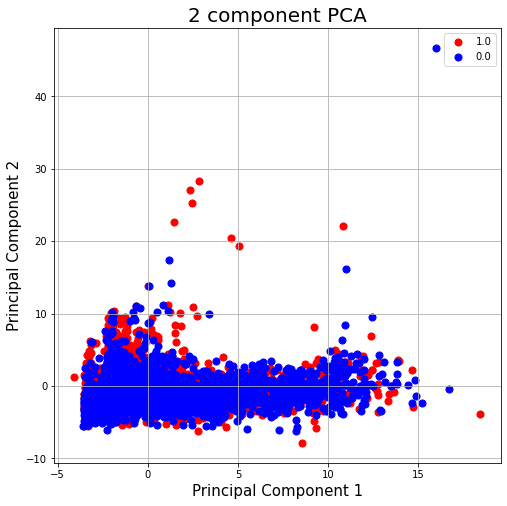

In [139]:
# Usamos esta gráfica para ver la distribución de los dos componentes principales
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['good_bad_flag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Podemos ver que los dos componentes principales no son suficientes para identificar las dos categorías que tenemos en la variable "good_bad_flag".
Pasaremo entonces a buscar métodos mediante los cuales el PCA nos aporte más información.

## PCA todas las variables 




In [173]:
# Creamos la instancia del modelo
pca1 = PCA()

# Adaptamos las variables
X_train1 = pca1.fit_transform(X_train)
X_test1 = pca1.transform(X_test)

In [174]:
#Vamos a buscar la varianza dependiendo de la cantidad de componentes que usemos (n)
explained_variance = pca1.explained_variance_ratio_
print(explained_variance)

[1.61178052e-01 9.21939784e-02 6.98501943e-02 5.35670411e-02
 4.85522150e-02 3.04774202e-02 2.45087874e-02 2.16437864e-02
 1.87115303e-02 1.75215968e-02 1.62075018e-02 1.59067302e-02
 1.55413239e-02 1.50621804e-02 1.46655214e-02 1.40731072e-02
 1.36615210e-02 1.34899439e-02 1.34018180e-02 1.32436549e-02
 1.31456317e-02 1.29512418e-02 1.28361088e-02 1.27724254e-02
 1.25588669e-02 1.25325604e-02 1.24472390e-02 1.23498141e-02
 1.22067061e-02 1.21802858e-02 1.19865621e-02 1.18385973e-02
 1.16796693e-02 1.15624745e-02 1.12789699e-02 1.11589741e-02
 1.09573098e-02 1.09107972e-02 1.06053240e-02 1.01967056e-02
 9.34807813e-03 9.21932658e-03 8.80650040e-03 8.63838373e-03
 7.21574310e-03 4.94474401e-03 3.79305202e-03 3.51735194e-03
 3.30963804e-03 2.91351534e-03 2.31763620e-03 1.98568592e-03
 1.48743887e-03 1.36066880e-03 1.30656994e-03 1.11481331e-03
 1.09760206e-03 1.03634904e-03 9.36759096e-04 8.57124204e-04
 6.55174662e-04 5.68115359e-04 3.92082518e-04 3.15891774e-04
 2.82572248e-04 1.893678

Text(0, 0.5, 'Explained variance (%)')

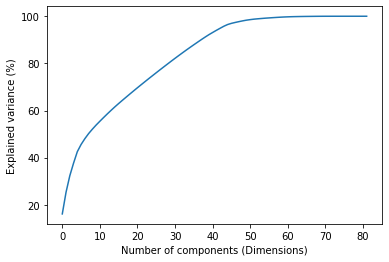

In [70]:
# Pintamos el gráfico que nos permite ver el % de varianza dependiendo del número de componentes que usemos
plt.plot(np.cumsum(pca1.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")


De la explicación de varianza vemos que de la primera variable depende el 16% de la varianza. Además podemos reconocer por el gráfico que necesitaríamos unas 45 componentes para superar el 80% de la variabilidad

In [156]:
# Aplicamos un Random forest para conocer la accuracy de la predicción

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(max_depth=2, random_state=0)
logistic_regresion_classifier = LogisticRegression(solver = 'lbfgs')

random_forest_classifier.fit(X_train1, y_train)
logistic_regresion_classifier.fit(X_train1, y_train)

# Predecimos los resultados del test set
y_pred1 = random_forest_classifier.predict(X_test1)
y_pred2 = logistic_regresion_classifier.predict(X_test1)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)
print('Confusion matrix Random forest\n', cm1)
print('Random forest score: ', accuracy_score(y_test, y_pred1))

# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'

#  Make an instance of the Model
LR_classifier = LogisticRegression(solver = 'lbfgs')


# Predict for various 
print('---------------------------------------------')
print('Confusion matrix logistic regresion \n', cm2)
print('Logistic regresion score:', logistic_regresion_classifier.score(X_test1, y_test))


Confusion matrix Random forest
 [[710   0]
 [451   0]]
Random forest score:  0.611541774332472
---------------------------------------------
Confusion matrix logistic regresion 
 [[513 197]
 [295 156]]
Logistic regresion score: 0.5762273901808785


## PCA Componentes 80% variabilidad





Vamos a usar el PCA con n numero de componentes que cumplan el 80% de varianza


In [161]:
pca2 = PCA(n_components=.80)

X_train2 = pca2.fit_transform(X_train)
X_test2 = pca2.transform(X_test)


PCA(n_components=0.8)


In [51]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [158]:

# Aplicamos un Random forest para conocer la accuracy de la predicción

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(max_depth=2, random_state=0)
logistic_regresion_classifier = LogisticRegression(solver = 'lbfgs')

random_forest_classifier.fit(X_train2, y_train)
logistic_regresion_classifier.fit(X_train2, y_train)

# Predecimos los resultados del test set
y_pred1 = random_forest_classifier.predict(X_test2)
y_pred2 = logistic_regresion_classifier.predict(X_test2)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)
print('Confusion matrix Random forest\n', cm1)
print('Random forest score: ', accuracy_score(y_test, y_pred1))

# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'

#  Make an instance of the Model
LR_classifier = LogisticRegression(solver = 'lbfgs')


# Predict for various 
print('---------------------------------------------')
print('Confusion matrix logistic regresion \n', cm2)
print('Logistic regresion score:', logistic_regresion_classifier.score(X_test2, y_test))

Confusion matrix Random forest
 [[676  34]
 [388  63]]
Random forest score:  0.6365202411714039
---------------------------------------------
Confusion matrix logistic regresion 
 [[645  65]
 [344 107]]
Logistic regresion score: 0.6477174849267873


ANALISIS!!!!!!




# Fin